In [5]:
# https://colab.research.google.com/drive/1IJkrrV-D7boSCLVKhi7t5docRYqORtm3#scrollTo=blNYA6yzzuXY

from contextlib import contextmanager
from copy import deepcopy
import math
from models.autoencoder import *
from IPython import display
from matplotlib import pyplot as plt
import torch
from torch import optim, nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import datasets, transforms, utils
from torchvision.transforms import functional as TF
from torchvision.utils import save_image, make_grid
from tqdm.notebook import tqdm, trange

In [10]:
# Utilities

@contextmanager
def train_mode(model, mode=True):
    """A context manager that places a model into training mode and restores
    the previous mode on exit."""
    modes = [module.training for module in model.modules()]
    try:
        yield model.train(mode)
    finally:
        for i, module in enumerate(model.modules()):
            module.training = modes[i]


def eval_mode(model):
    """A context manager that places a model into evaluation mode and restores
    the previous mode on exit."""
    return train_mode(model, False)


@torch.no_grad()
def ema_update(model, averaged_model, decay):
    """Incorporates updated model parameters into an exponential moving averaged
    version of a model. It should be called after each optimizer step."""
    model_params = dict(model.named_parameters())
    averaged_params = dict(averaged_model.named_parameters())
    assert model_params.keys() == averaged_params.keys()

    for name, param in model_params.items():
        averaged_params[name].mul_(decay).add_(param, alpha=1 - decay)

    model_buffers = dict(model.named_buffers())
    averaged_buffers = dict(averaged_model.named_buffers())
    assert model_buffers.keys() == averaged_buffers.keys()

    for name, buf in model_buffers.items():
        averaged_buffers[name].copy_(buf)


In [11]:
# Define the model (a residual U-Net)

class ResidualBlock(nn.Module):
    def __init__(self, main, skip=None):
        super().__init__()
        self.main = nn.Sequential(*main)
        self.skip = skip if skip else nn.Identity()

    def forward(self, input):
        return self.main(input) + self.skip(input)


class ResConvBlock(ResidualBlock):
    def __init__(self, c_in, c_mid, c_out, dropout_last=True):
        skip = None if c_in == c_out else nn.Conv2d(c_in, c_out, 1, bias=False)
        super().__init__([
            nn.Conv2d(c_in, c_mid, 3, padding=1),
            nn.Dropout2d(0.1, inplace=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(c_mid, c_out, 3, padding=1),
            nn.Dropout2d(0.1, inplace=True) if dropout_last else nn.Identity(),
            nn.ReLU(inplace=True),
        ], skip)


class SkipBlock(nn.Module):
    def __init__(self, main, skip=None):
        super().__init__()
        self.main = nn.Sequential(*main)
        self.skip = skip if skip else nn.Identity()

    def forward(self, input):
        return torch.cat([self.main(input), self.skip(input)], dim=1)


class FourierFeatures(nn.Module):
    def __init__(self, in_features, out_features, std=1.):
        super().__init__()
        assert out_features % 2 == 0
        self.weight = nn.Parameter(torch.randn([out_features // 2, in_features]) * std)

    def forward(self, input):
        f = 2 * math.pi * input @ self.weight.T
        return torch.cat([f.cos(), f.sin()], dim=-1)


def expand_to_planes(input, shape):
    return input[..., None, None].repeat([1, 1, shape[2], shape[3]])


class Diffusion(nn.Module):
    def __init__(self,
                 con_dim=None,
                 con_emb: int=0):
        super().__init__()
        c = 64  # The base channel count

        # The inputs to timestep_embed will approximately fall into the range
        # -10 to 10, so use std 0.2 for the Fourier Features.
        self.timestep_embed = FourierFeatures(1, 16, std=0.2)
        self.class_embed = nn.Embedding(10, 4)

        # latent information f(X)
        if con_dim is not None:
            self.con_embd = nn.Linear(con_dim, con_emb)


        self.net = nn.Sequential(   # 32x32
            ResConvBlock(3 + 16 + 4 + con_emb, c, c),
            ResConvBlock(c, c, c),
            SkipBlock([
                nn.AvgPool2d(2),  # 32x32 -> 16x16
                ResConvBlock(c, c * 2, c * 2),
                ResConvBlock(c * 2, c * 2, c * 2),
                SkipBlock([
                    nn.AvgPool2d(2),  # 16x16 -> 8x8
                    ResConvBlock(c * 2, c * 4, c * 4),
                    ResConvBlock(c * 4, c * 4, c * 4),
                    SkipBlock([
                        nn.AvgPool2d(2),  # 8x8 -> 4x4
                        ResConvBlock(c * 4, c * 8, c * 8),
                        ResConvBlock(c * 8, c * 8, c * 8),
                        ResConvBlock(c * 8, c * 8, c * 8),
                        ResConvBlock(c * 8, c * 8, c * 4),
                        nn.Upsample(scale_factor=2),
                    ]),  # 4x4 -> 8x8
                    ResConvBlock(c * 8, c * 4, c * 4),
                    ResConvBlock(c * 4, c * 4, c * 2),
                    nn.Upsample(scale_factor=2),
                ]),  # 8x8 -> 16x16
                ResConvBlock(c * 4, c * 2, c * 2),
                ResConvBlock(c * 2, c * 2, c),
                nn.Upsample(scale_factor=2),
            ]),  # 16x16 -> 32x32
            ResConvBlock(c * 2, c, c),
            ResConvBlock(c, c, 3, dropout_last=False),
        )

    def forward(self, input, log_snrs, cond, latent_con=None):
        timestep_embed = expand_to_planes(self.timestep_embed(log_snrs[:, None]), input.shape)
        class_embed = expand_to_planes(self.class_embed(cond), input.shape)
        if latent_con is not None:
            latent_embed = expand_to_planes(self.con_embd(latent_con))
            return self.net(torch.cat([input, class_embed, timestep_embed, latent_embed], dim=1))
        else:
            return self.net(torch.cat([input, class_embed, timestep_embed], dim=1))

In [12]:
# Define the noise schedule and sampling loop

def get_alphas_sigmas(log_snrs):
    """Returns the scaling factors for the clean image (alpha) and for the
    noise (sigma), given the log SNR for a timestep."""
    return log_snrs.sigmoid().sqrt(), log_snrs.neg().sigmoid().sqrt()


def get_ddpm_schedule(t):
    """Returns log SNRs for the noise schedule from the DDPM paper."""
    # return -torch.special.expm1(1e-4 + 10 * t**2).log()
    return -(torch.exp(1e-4 + 10 * t**2)-1).log()


@torch.no_grad()
def sample(model, x, steps, eta, classes):
    """Draws samples from a model given starting noise."""
    ts = x.new_ones([x.shape[0]])

    # Create the noise schedule
    t = torch.linspace(1, 0, steps + 1)[:-1]
    log_snrs = get_ddpm_schedule(t)
    alphas, sigmas = get_alphas_sigmas(log_snrs)

    # The sampling loop
    for i in range(steps):

        # Get the model output (v, the predicted velocity)
        with torch.cuda.amp.autocast():
            v = model(x, ts * log_snrs[i], classes).float()

        # Predict the noise and the denoised image
        pred = x * alphas[i] - v * sigmas[i]
        eps = x * sigmas[i] + v * alphas[i]

        # If we are not on the last timestep, compute the noisy image for the
        # next timestep.
        if i < steps - 1:
            # If eta > 0, adjust the scaling factor for the predicted noise
            # downward according to the amount of additional noise to add
            ddim_sigma = eta * (sigmas[i + 1]**2 / sigmas[i]**2).sqrt() * \
                (1 - alphas[i]**2 / alphas[i + 1]**2).sqrt()
            adjusted_sigma = (sigmas[i + 1]**2 - ddim_sigma**2).sqrt()

            # Recombine the predicted noise and predicted denoised image in the
            # correct proportions for the next step
            x = pred * alphas[i + 1] + eps * adjusted_sigma

            # Add the correct amount of fresh noise
            if eta:
                x += torch.randn_like(x) * ddim_sigma

    # If we are on the last timestep, output the denoised image
    return pred

The noise schedule:


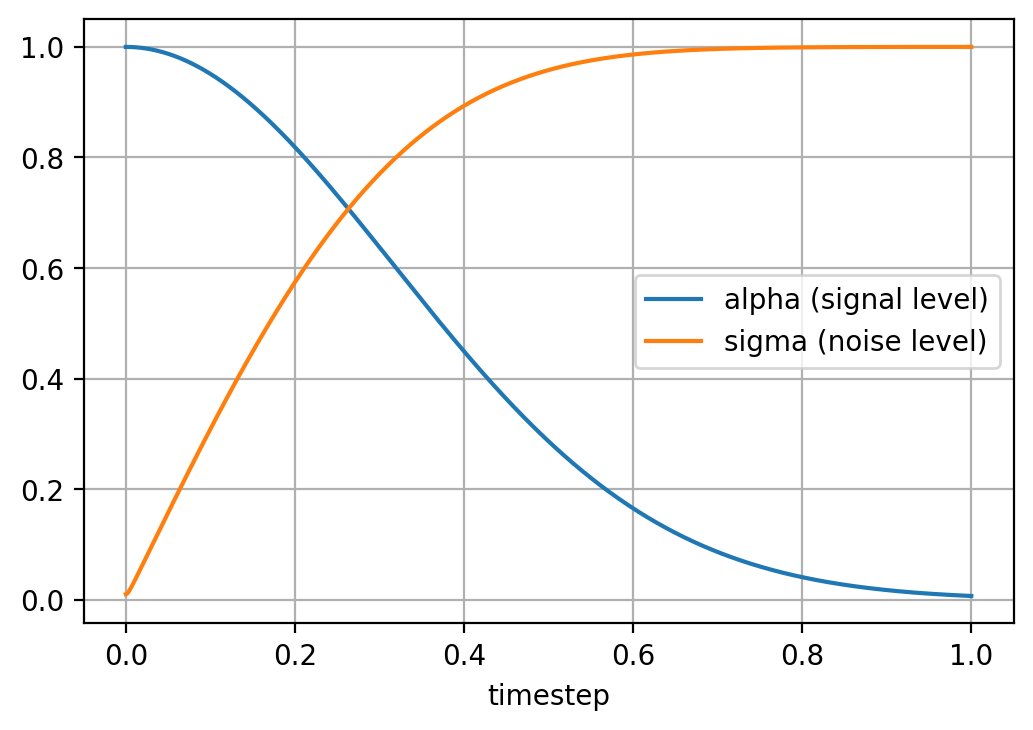

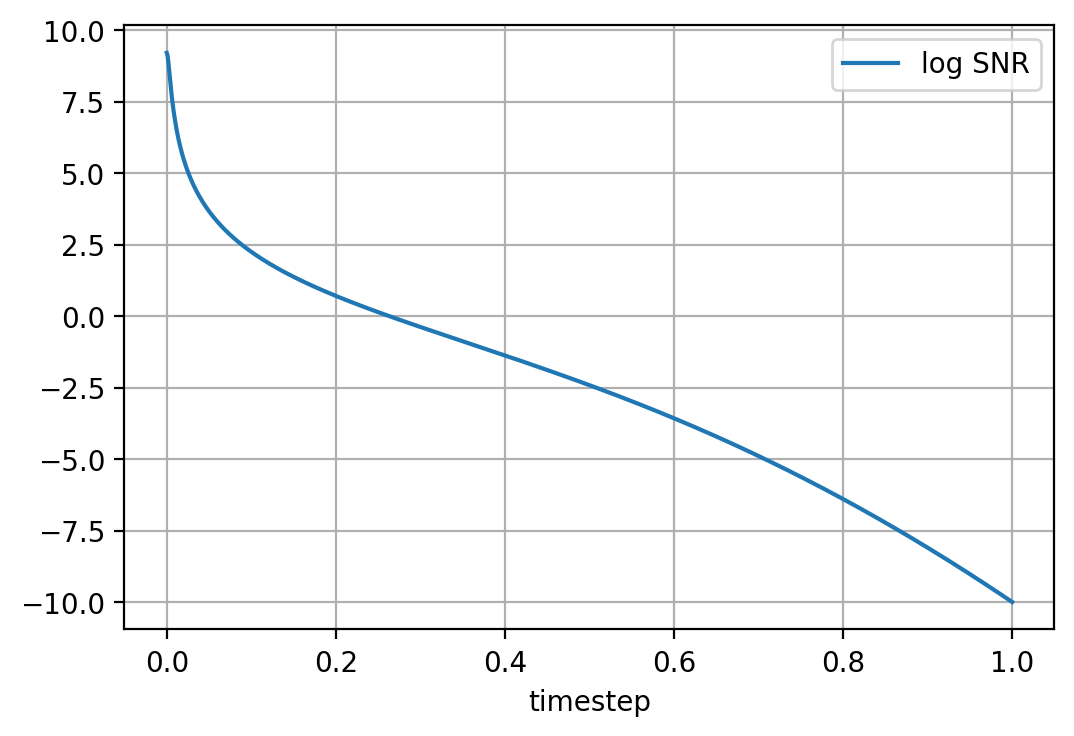

In [13]:
# Visualize the noise schedule

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 100

t_vis = torch.linspace(0, 1, 1000)
log_snrs_vis = get_ddpm_schedule(t_vis)
alphas_vis, sigmas_vis = get_alphas_sigmas(log_snrs_vis)

print('The noise schedule:')

plt.plot(t_vis, alphas_vis, label='alpha (signal level)')
plt.plot(t_vis, sigmas_vis, label='sigma (noise level)')
plt.legend()
plt.xlabel('timestep')
plt.grid()
plt.show()

plt.plot(t_vis, log_snrs_vis, label='log SNR')
plt.legend()
plt.xlabel('timestep')
plt.grid()
plt.show()


In [14]:
# Prepare the dataset

batch_size = 100

tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])
train_set = datasets.CIFAR10('../../Data/cifar10/', train=True, download=True, transform=tf)
train_dl = data.DataLoader(train_set, batch_size, shuffle=True,
                           num_workers=4, persistent_workers=True, pin_memory=False)
val_set = datasets.CIFAR10('../../Data/cifar10/', train=False, download=True, transform=tf)
val_dl = data.DataLoader(val_set, batch_size,
                         num_workers=4, persistent_workers=True, pin_memory=False)


Files already downloaded and verified
Files already downloaded and verified


In [15]:
# Create the model and optimizer

seed = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
torch.manual_seed(0)

model = Diffusion().to(device)
model_ema = deepcopy(model)
print('Model parameters:', sum(p.numel() for p in model.parameters()))

opt = optim.Adam(model.parameters(), lr=2e-4)
scaler = torch.cuda.amp.GradScaler()
epoch = 0

# Use a low discrepancy quasi-random sequence to sample uniformly distributed
# timesteps. This considerably reduces the between-batch variance of the loss.
rng = torch.quasirandom.SobolEngine(1, scramble=True)

Using device: cuda
Model parameters: 23211315


In [16]:
ema_decay = 0.998

# The number of timesteps to use when sampling
steps = 500

# The amount of noise to add each timestep when sampling
# 0 = no noise (DDIM)
# 1 = full noise (DDPM)
eta = 1.


def eval_loss(model, rng, reals, classes):
    # Draw uniformly distributed continuous timesteps
    t = rng.draw(reals.shape[0])[:, 0].to(device)

    # Calculate the noise schedule parameters for those timesteps
    log_snrs = get_ddpm_schedule(t)
    alphas, sigmas = get_alphas_sigmas(log_snrs)
    weights = log_snrs.exp() / log_snrs.exp().add(1)

    # Combine the ground truth images and the noise
    alphas = alphas[:, None, None, None]
    sigmas = sigmas[:, None, None, None]
    noise = torch.randn_like(reals)
    noised_reals = reals * alphas + noise * sigmas
    targets = noise * alphas - reals * sigmas

    # Compute the model output and the loss.
    with torch.cuda.amp.autocast():
        v = model(noised_reals, log_snrs, classes)
        return (v - targets).pow(2).mean([1, 2, 3]).mul(weights).mean()


def train():
    for i, (reals, classes) in enumerate(tqdm(train_dl)):
        opt.zero_grad()
        reals = reals.to(device)
        classes = classes.to(device)

        # Evaluate the loss
        loss = eval_loss(model, rng, reals, classes)

        # Do the optimizer step and EMA update
        scaler.scale(loss).backward()
        scaler.step(opt)
        ema_update(model, model_ema, 0.95 if epoch < 20 else ema_decay)
        scaler.update()

        if i % 50 == 0:
            tqdm.write(f'Epoch: {epoch}, iteration: {i}, loss: {loss.item():g}')


@torch.no_grad()
@torch.random.fork_rng()
@eval_mode(model_ema)
def val():
    tqdm.write('\nValidating...')
    torch.manual_seed(seed)
    rng = torch.quasirandom.SobolEngine(1, scramble=True)
    total_loss = 0
    count = 0
    for i, (reals, classes) in enumerate(tqdm(val_dl)):
        reals = reals.to(device)
        classes = classes.to(device)

        loss = eval_loss(model_ema, rng, reals, classes)

        total_loss += loss.item() * len(reals)
        count += len(reals)
    loss = total_loss / count
    tqdm.write(f'Validation: Epoch: {epoch}, loss: {loss:g}')


@torch.no_grad()
@torch.random.fork_rng()
@eval_mode(model_ema)
def demo():
    tqdm.write('\nSampling...')
    torch.manual_seed(seed)

    noise = torch.randn([100, 3, 32, 32], device=device)
    fakes_classes = torch.arange(10, device=device).repeat_interleave(10, 0)
    fakes = sample(model_ema, noise, steps, eta, fakes_classes)

    grid = utils.make_grid(fakes, 10).cpu()
    filename = f'demo_{epoch:05}.png'
    TF.to_pil_image(grid.add(1).div(2).clamp(0, 1)).save(filename)
    display.display(display.Image(filename))
    tqdm.write('')


def save():
    filename = 'cifar_diffusion.pth'
    obj = {
        'model': model.state_dict(),
        'model_ema': model_ema.state_dict(),
        'opt': opt.state_dict(),
        'scaler': scaler.state_dict(),
        'epoch': epoch,
    }
    torch.save(obj, filename)


# max_epoches = 100
# try:
#     val()
#     demo()
#     for epoch in range(max_epoches):
#         train()
#         if epoch % 5 == 0:
#             val()
#             demo()
#         save()
# except KeyboardInterrupt:
#     pass
import os

sample_dir = './results/condiff'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

max_epoches = 100
for epoch in range(max_epoches):
    for i, (reals, classes) in enumerate(train_dl):
        opt.zero_grad()
        reals = reals.to(device)
        classes = classes.to(device)

        # Evaluate the loss
        loss = eval_loss(model, rng, reals, classes)

        # Do the optimizer step and EMA update
        scaler.scale(loss).backward()
        scaler.step(opt)
        ema_update(model, model_ema, 0.95 if epoch < 20 else ema_decay)
        scaler.update()

        if i % 50 == 0:
            tqdm.write(f'Epoch: {epoch}/{max_epoches}, iteration: {i}/{len(train_dl)}, loss: {loss.item():g}')

    with torch.no_grad():
        noise = torch.randn([reals.shape[0], 3, 32, 32], device=device)
        fakes = sample(model_ema, noise, steps, eta, classes)
        x_concat = torch.cat([reals, fakes], dim=3).add(1).div(2)
        # plt.imshow(make_grid(fakes, nrow=2).add(1).div(2).permute(1,2,0).cpu(), vmin=0., vmax=1.)
        save_image(x_concat, os.path.join(sample_dir, 'diffuse-{}.png'.format(epoch+1)), nrow=10)



Epoch: 0/100, iteration: 0/500, loss: 0.224827
Epoch: 0/100, iteration: 50/500, loss: 0.115027
Epoch: 0/100, iteration: 100/500, loss: 0.0787143
Epoch: 0/100, iteration: 150/500, loss: 0.0698309
Epoch: 0/100, iteration: 200/500, loss: 0.0610412
Epoch: 0/100, iteration: 250/500, loss: 0.0608712
Epoch: 0/100, iteration: 300/500, loss: 0.0525978
Epoch: 0/100, iteration: 350/500, loss: 0.0553811
Epoch: 0/100, iteration: 400/500, loss: 0.0525362
Epoch: 0/100, iteration: 450/500, loss: 0.0551946
Epoch: 1/100, iteration: 0/500, loss: 0.0574263
Epoch: 1/100, iteration: 50/500, loss: 0.0537793
Epoch: 1/100, iteration: 100/500, loss: 0.0513822
Epoch: 1/100, iteration: 150/500, loss: 0.0477491
Epoch: 1/100, iteration: 200/500, loss: 0.0483079
Epoch: 1/100, iteration: 250/500, loss: 0.0505053
Epoch: 1/100, iteration: 300/500, loss: 0.048722
Epoch: 1/100, iteration: 350/500, loss: 0.0511589
Epoch: 1/100, iteration: 400/500, loss: 0.0530104
Epoch: 1/100, iteration: 450/500, loss: 0.0493659
Epoch: 2/

In [19]:
_, (x, y) = next(enumerate(val_dl))
x = x[0:4]
y = y[0:4]

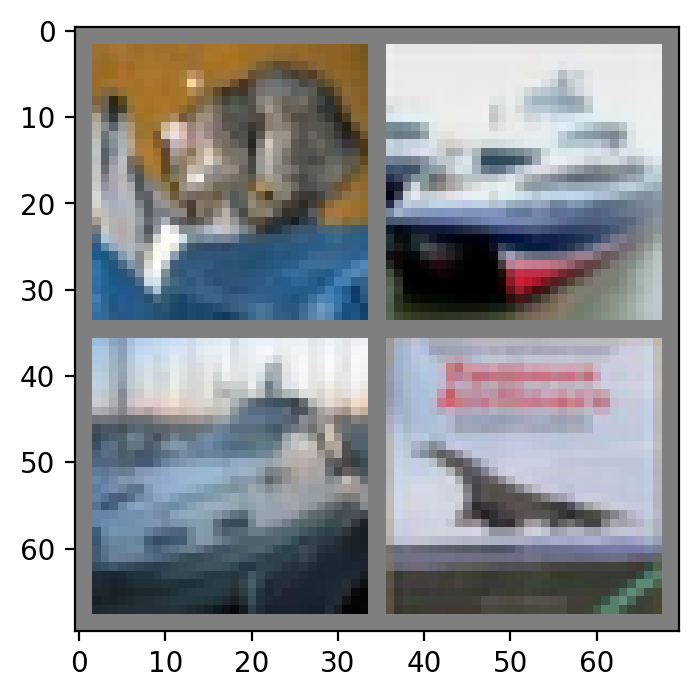

In [20]:
plt.imshow(make_grid(x, nrow=2).add(1).div(2).permute(1,2,0).cpu(), vmin=0., vmax=1.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


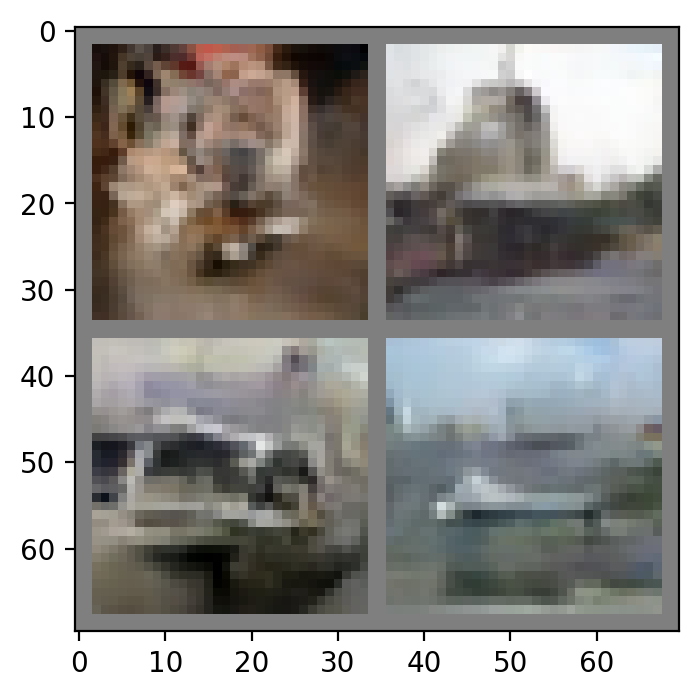

In [21]:
noise = torch.randn([4, 3, 32, 32], device=device)
y = y.to(device)
fakes = sample(model_ema, noise, steps, eta, y)
plt.imshow(make_grid(fakes, nrow=2).add(1).div(2).permute(1,2,0).cpu(), vmin=0., vmax=1.)